In [1]:

'''REQUIRED LIBRARIES'''
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

import plotly.graph_objs as go


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose


2024-03-16 13:12:02.114060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 13:12:02.114438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 13:12:02.181166: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 13:12:02.305640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 13:12:03.767776: W tensorflow/compiler/tf2

## Check if GPU accelaration is running (applies for Windows users with Nvidia card)

In [2]:

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-03-16 13:12:06.773652: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:12:06.976221: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:12:06.976289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Load the Data

In [3]:
data_path = '../raw_data/archive/rendered_chairs/folder_b/image1.png'

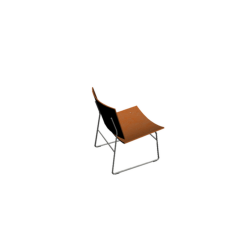

In [4]:
#Print an image to make sure files are there
image = mpimg.imread(data_path)

plt.figure(figsize=(3,3))
# Display the image using Matplotlib
plt.imshow(image,cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

In [5]:
image.shape

(600, 600, 3)

In [6]:
def load_images_from_folder(filename : str, *resolution:int):
    '''
    inputs folder location as string and outputs the containing images as an array
    '''
    resolution=resolution
    # Set the path to the folder containing the images
    data_folder = filename

    # Initialize an empty list to store the images
    images = []

    # Iterate over the files in the data folder
    for filename in os.listdir(data_folder):
        # Check if the file is an image
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Load the image
            img_path = os.path.join(data_folder, filename)
            img = Image.open(img_path)
            # Resize the image to (100, 100) ---- comment out if not needed
            img = img.resize((100,100))
            # Convert the image to RGB if it's not already in RGB format ---- comment out if not needed
            #if img.mode != 'RGB':
                #img = img.convert('RGB')
                
            # Append the image to the list
            images.append(img)

    # Convert the list of images to an array
    images_array = np.array([np.array(img) for img in images])

    return images_array


In [7]:
train_path_1 = '../raw_data/archive/greyscale/'
test_path = '../raw_data/archive/greyscale_test/'

train_path_2 = '../raw_data/archive/prep_grey/'
train_path_3 = '../raw_data/archive/preprocessed2000_grey/'

#train_path_4 = '..//raw_data/archive/rendered_chairs/folder_b/'

In [8]:
#train_images = load_images_from_folder(train_path,28)
test_images = load_images_from_folder(test_path,100)

train_images_1 = load_images_from_folder(train_path_1,100)
train_images_2 = load_images_from_folder(train_path_2,100)
train_images_3 = load_images_from_folder(train_path_3,100)

#train_images_4 = load_images_from_folder(train_path_4,100)

NameError: name 'train_images_4' is not defined

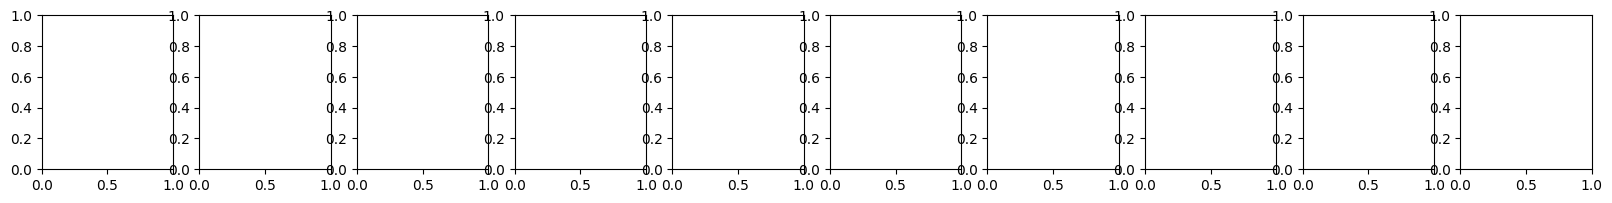

In [9]:
# Display 10 images horizontally next to each other
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

# Iterate over the first 10 images and display them
for i in range(10):
    axes[i].imshow(train_images_4[i],cmap='gray')
    axes[i].axis('off')

plt.show()

In [ ]:
train_images_4.shape #check the shape of the train set

In [10]:
train_images=np.concatenate([train_images_1,train_images_2,train_images_3],axis=0)

In [11]:
train_images.shape

(5913, 100, 100)

## Preprocessing the images

In [12]:
# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

#train_2_images= train_2_images/255.0
#train_images_2 = np.expand_dims(train_images,-1).astype('float32')

## Auto encoder model

### Kitt model

#### Building the model

In [14]:
'''
KITT MODEL
'''

### CONSTRUCT THE ENCODER FIRST

def build_encoder_kitt(latent_dimension):
    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()

    encoder.add(Conv2D(16, (3,3), input_shape=(100, 100,1), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(8, (3, 3), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(8, (3, 3), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))

    return encoder


#THEN CONSTRUCT THE DECODER

def build_decoder_kitt(latent_dimension):

    decoder = Sequential()

    decoder.add(Dense(25*25*8,input_shape=(latent_dimension,),activation='tanh'))
    decoder.add(Reshape([25,25,8]))
    decoder.add(Conv2DTranspose(16,(2,2),strides=(2, 2),padding='same',activation='relu'))
    decoder.add(Conv2DTranspose(1,(2,2),strides=(2,2),padding='same',activation='relu'))

    return decoder

In [15]:
decoder_kitt = build_decoder_kitt(100)
encoder_kitt = build_encoder_kitt(100)

2024-03-15 12:52:03.263015: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 12:52:03.263127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 12:52:03.263161: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 12:52:03.477164: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 12:52:03.477237: I external/local_xla/xla/stream_executor

In [16]:
encoder_kitt.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 8)         584       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 8)        

In [17]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

def build_autoencoder_kitt(encoder, decoder):
    inp = Input((100, 100,1))
    encoded = encoder_kitt(inp)
    decoded = decoder_kitt(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

In [18]:
autoencoder_kitt = build_autoencoder_kitt(encoder_kitt,decoder_kitt)
autoencoder_kitt.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 100)               82004     
                                                                 
 sequential (Sequential)     (None, 100, 100, 1)       505593    
                                                                 
Total params: 587597 (2.24 MB)
Trainable params: 587597 (2.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
autoencoder_kitt.compile(loss='mse',optimizer='nadam')

In [20]:
autoencoder_kitt.fit(train_images,train_images,epochs=30,batch_size=16)

Epoch 1/30


2024-03-15 12:52:06.573261: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-15 12:52:08.463752: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fee694ca680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-15 12:52:08.463802: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-03-15 12:52:08.483630: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710507128.638332  172144 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


370/370 [==============================] - 11s 13ms/step - loss: 0.1572
Epoch 2/30
370/370 [==============================] - 4s 11ms/step - loss: 0.0411
Epoch 3/30
370/370 [==============================] - 4s 11ms/step - loss: 0.0230
Epoch 4/30
370/370 [==============================] - 4s 11ms/step - loss: 0.0197
Epoch 5/30
370/370 [==============================] - 4s 11ms/step - loss: 0.0179
Epoch 6/30
370/370 [==============================] - 4s 11ms/step - loss: 0.0166
Epoch 7/30
370/370 [==============================] - 4s 11ms/step - loss: 0.0156
Epoch 8/30
370/370 [==============================] - 4s 11ms/step - loss: 0.0148
Epoch 9/30
370/370 [==============================] - 4s 11ms/step - loss: 0.0142
Epoch 10/30
370/370 [==============================] - 4s 12ms/step - loss: 0.0136
Epoch 11/30
370/370 [==============================] - 4s 12ms/step - loss: 0.0132
Epoch 12/30
370/370 [==============================] - 4s 11ms/step - loss: 0.0128
Epoch 13/30
370/370 [==

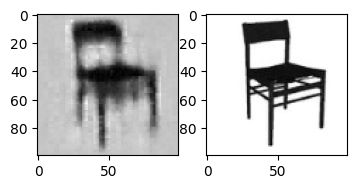

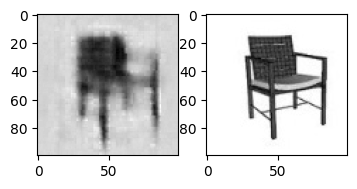

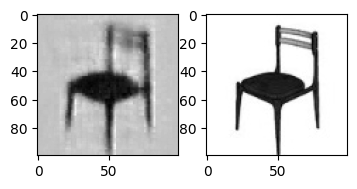

In [21]:
# you can now display an image to see it is reconstructed well -- or not :)
prediction = autoencoder_kitt.predict(train_images, verbose=0, batch_size=100)

for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    ax1.imshow(prediction[i].reshape(100,100,1),cmap='gray')
    ax2.imshow(train_images[i].reshape(100,100,1),cmap='gray')
    plt.show()

In [22]:
#create an array with all the encodings
im_encoded = encoder_kitt.predict(train_images,verbose=1)
print (im_encoded.shape)
type(im_encoded)

185/185 [==============================] - 1s 3ms/step
(5913, 100)


numpy.ndarray

#### check for optimum latent space dimension

In [ ]:
latent_dimensions = list(range(100,300,10))

test_errors = []
for latent_dimension in latent_dimensions:
    print(" ")
    print("-"*80)
    print(f"Running the autoencoder with latent_dimension = {latent_dimension}")
    print("-"*80)
    encoder_kitt = build_encoder_kitt(latent_dimension=latent_dimension)
    decoder_kitt = build_decoder_kitt(latent_dimension=latent_dimension)
    autoencoder_kitt = build_autoencoder_kitt(encoder_kitt, decoder_kitt)
    autoencoder_kitt.compile(loss='mse',optimizer='nadam')
    autoencoder_kitt.fit(train_images, train_images, epochs=20, batch_size=32)
    error = autoencoder_kitt.evaluate(test_images, test_images)
    test_errors.append(error)

In [ ]:

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(latent_dimensions,
            test_errors,
            color='black',
            linestyle='dashed',
            marker='o',
            markerfacecolor='#947FFF',
            markersize=10)
    # more
    ax.set_title('MSE Test Error vs. $Latent$ $Dimensions$', fontsize = 18)
    ax.set_xlabel('Latent Dimension', fontsize = 14)
    ax.set_ylabel('MSE Score', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

    # focusing
    ax.scatter(8,test_errors[2],c='#00ad8b',s=700)

    # annotate
    ax.annotate("Elbow Method ?",
               xy=(8,test_errors[2]),
                xytext=(8+0.25,test_errors[2]+0.0025),
                arrowprops=dict(arrowstyle='-|>',
                                fc="k",
                                ec="k",
                                lw=2),
                bbox=dict(pad=5, facecolor="none", edgecolor="none")
               )


    plt.show();
    
    print ('Based on the results of this, can go back and change the latent dimension')

----------------------------------------------------------------

### CHAT GTP Model

#### Building the model

In [23]:
'''
GHATGPT MODEL
'''

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,Flatten
from tensorflow.keras.models import Model

def build_encoder_gpt(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return Model(input_img, encoded)

# At this point the representation is (13, 13, 128)???? --- please check that


def build_decoder_gpt(encoded_shape):
    input_encoded = Input(shape=encoded_shape)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output should match input shape
    return Model(input_encoded, decoded)


# Define input shape
input_shape = (100, 100, 1)

# Build encoder and decoder
encoder_gpt = build_encoder_gpt(input_shape)
print(encoder_gpt.output_shape)
decoder_gpt = build_decoder_gpt(encoder_gpt.output_shape[1:])

# Combine encoder and decoder into autoencoder
input_img = Input(shape=input_shape)
encoded = encoder_gpt(input_img)
decoded = decoder_gpt(encoded)
autoencoder_gpt = Model(input_img, decoded)

# Compile the autoencoder
autoencoder_gpt.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
autoencoder_gpt.fit(train_images, train_images, epochs=20, batch_size=32, shuffle=True)


(None, 13, 13, 128)
Epoch 1/20
185/185 [==============================] - 11s 31ms/step - loss: 0.3498
Epoch 2/20
185/185 [==============================] - 4s 23ms/step - loss: 0.3060
Epoch 3/20
185/185 [==============================] - 4s 22ms/step - loss: 0.3023
Epoch 4/20
185/185 [==============================] - 4s 22ms/step - loss: 0.2996
Epoch 5/20
185/185 [==============================] - 4s 22ms/step - loss: 0.2968
Epoch 6/20
185/185 [==============================] - 4s 22ms/step - loss: 0.2968
Epoch 7/20
185/185 [==============================] - 4s 22ms/step - loss: 0.2949
Epoch 8/20
185/185 [==============================] - 4s 23ms/step - loss: 0.2945
Epoch 9/20
185/185 [==============================] - 4s 22ms/step - loss: 0.2948
Epoch 10/20
185/185 [==============================] - 4s 23ms/step - loss: 0.2960
Epoch 11/20
185/185 [==============================] - 4s 22ms/step - loss: 0.2953
Epoch 12/20
185/185 [==============================] - 4s 22ms/step - loss:

In [24]:
# Reconstruct chair images
num_chairs = 10

1/1 [==============================] - 0s 304ms/step


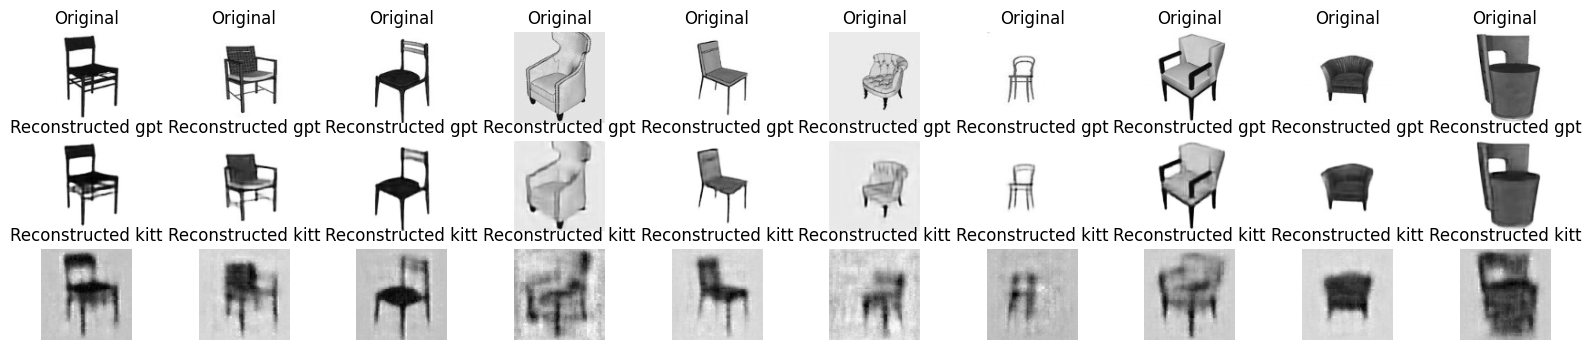

In [25]:
# Reconstruct chair images
num_chairs = 10
encoded_imgs = encoder_gpt.predict(train_images[:num_chairs])
decoded_imgs = decoder_gpt.predict(encoded_imgs)



# Display original and reconstructed faces
plt.figure(figsize=(20, 4))
for i in range(num_chairs):
    # Original images
    plt.subplot(3, num_chairs, i + 1)
    plt.imshow(train_images[i],cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Reconstructed images from gpt model
    plt.subplot(3, num_chairs, i + 1 + num_chairs)
    plt.imshow(decoded_imgs[i],cmap='gray')
    plt.title('Reconstructed gpt')
    plt.axis('off')
    
    # Reconstructed images from gpt model
    plt.subplot(3, num_chairs, i + 11 + num_chairs)
    plt.imshow(prediction[i],cmap='gray')
    plt.title('Reconstructed kitt')
    plt.axis('off')
    

    
    
plt.show()

## Creating interpolations

1/1 [==============================] - 0s 15ms/step


(-0.5, 99.5, 99.5, -0.5)

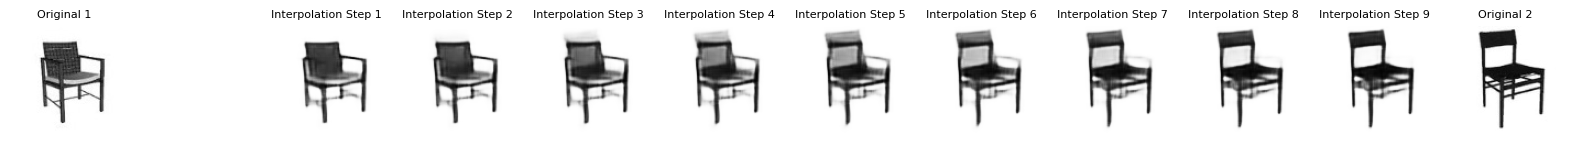

In [26]:
# Choose two images from the dataset
image1 = train_images[0]  # Assuming x_train is your dataset
image2 = train_images[1]

# Encode the images
encoded_image1 = encoder_gpt.predict(np.array([image1]))
encoded_image2 = encoder_gpt.predict(np.array([image2]))

# Interpolate between the encodings
interpolations = []
for i in range(10):  # 5 steps of interpolation
    alpha = i / 10.0
    interpolated_encoding = alpha * encoded_image1 + (1 - alpha) * encoded_image2
    interpolations.append(interpolated_encoding)

# Decode the interpolated encodings
decoded_interpolations = []
for encoding in interpolations:
    decoded_interpolations.append(decoder_gpt.predict(encoding))

    
# Visualize the reconstructed images of the interpolations
plt.figure(figsize=(20, 10))
# for i, reconstructed_image in enumerate(decoded_interpolations):
#     plt.subplot(1, 5, i + 1)
#     plt.imshow(reconstructed_image.squeeze())
#     plt.title(f'Interpolation Step {i + 1}')
#     plt.axis('off')
# plt.show()

# Plot the first original image
plt.subplot(1, 12, 1)
plt.imshow(image2,cmap='gray')
plt.title('Original 1',fontsize=8)
plt.axis('off')

# Plot the reconstructed images of the interpolations
for i, reconstructed_image in enumerate(decoded_interpolations):
    plt.subplot(1, 12, i + 3)
    plt.imshow(reconstructed_image.squeeze(),cmap='gray')
    plt.title(f'Interpolation Step {i + 1}',fontsize=8)
    plt.axis('off')

# Plot the second original image
plt.subplot(1, 12, 12)
plt.imshow(image1,cmap='gray')
plt.title('Original 2',fontsize=8)
plt.axis('off')


## visualize latent space with UMAP

In [27]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import umap

# Obtain encoded representations
encoded_data = encoder_gpt.predict(train_images)



# Flatten the encoded data
# Reshape the encoded data to flatten each encoded representation
encoded_data_flat = encoded_data.reshape((encoded_data.shape[0], -1))

# Apply UMAP to reduce dimensionality to 3D
umap_reducer = umap.UMAP(n_components=3, random_state=42)
latent_3d = umap_reducer.fit_transform(encoded_data_flat)


185/185 [==============================] - 0s 2ms/step


2024-03-15 12:56:12.381097: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 511640064 exceeds 10% of free system memory.
/home/alexp/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [28]:
# Extract image indices for each point in the latent space
image_indices = np.arange(len(train_images))

# Create an interactive 3D scatter plot with Plotly
scatter = go.Scatter3d(
    x=latent_3d[:, 0],
    y=latent_3d[:, 1],
    z=latent_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='blue',
        opacity=0.8
    ),
    hoverinfo='text',
    text=image_indices  # Show image indices on hover
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X Label'),
        yaxis=dict(title='Y Label'),
        zaxis=dict(title='Z Label')
    ),
    title='UMAP 3D Visualization of Latent Space'
)

fig = go.Figure(data=[scatter], layout=layout)
fig.show()

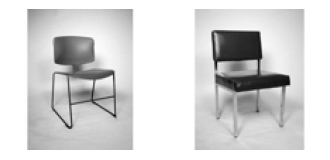

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))


axes[0].imshow(train_images[1964],cmap='gray')
axes[0].axis('off')

axes[1].imshow(train_images[2662],cmap='gray')
axes[1].axis('off')

plt.show()

----------------

----------------------------------

## VAE Autoencoders


In [13]:
def plot_reconstructions(model, images=train_images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="gray")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="gray")
        plt.axis("off")

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense, ZeroPadding2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def sampling(args):
    '''Reparametrization trick z-mu +sigma +epsilon'''
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_encoder_vae(input_shape, encoding_dim):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    flattened = Flatten()(x)
    z_mean = Dense(encoding_dim, name='z_mean')(flattened)
    z_log_var = Dense(encoding_dim, name='z_log_var')(flattened)
    z = Lambda(sampling, output_shape=(encoding_dim,), name='z')([z_mean, z_log_var])
    return Model(input_img, [z_mean, z_log_var, z])

def build_decoder_vae(encoded_dim, input_shape):
    input_encoded = Input(shape=(encoded_dim,))
    x = Dense(12 * 12 * 128, activation='relu')(input_encoded)  # Calculate the number of neurons to match the desired shape
    x = Reshape((12, 12, 128))(x)  # Reshape to match the shape after the last pooling layer in the encoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Change padding to 'same'
    x = UpSampling2D((2, 2))(x)
    x = ZeroPadding2D(2)(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Change padding to 'same'
    return Model(input_encoded, decoded)

# Define input shape and encoding dimension
input_shape = (100, 100, 1)
encoding_dim = 100  # Example encoding dimension

# Build encoder and decoder
encoder_vae = build_encoder_vae(input_shape, encoding_dim)
print(encoder_vae.output_shape)

decoder_vae = build_decoder_vae(encoding_dim, input_shape)

# Combine encoder and decoder into autoencoder
input_img = Input(shape=input_shape)
z_mean, z_log_var, z = encoder_vae(input_img)
decoded = decoder_vae(z)
autoencoder_vae = Model(input_img, decoded)

# Define the VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(decoded))
reconstruction_loss *= input_shape[0] * input_shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
autoencoder_vae.add_loss(vae_loss)

# Compile the VAE
autoencoder_vae.compile(optimizer='adam')

# Train the model
autoencoder_vae.fit(train_images,train_images, epochs=100, batch_size=32, shuffle=True)


2024-03-16 13:12:49.574879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:12:49.574974: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:12:49.575005: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:12:49.777796: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:12:49.777880: I external/local_xla/xla/stream_executor

[(None, 100), (None, 100), (None, 100)]
Epoch 1/100


2024-03-16 13:12:53.144282: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-16 13:12:57.524382: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f12080eff00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-16 13:12:57.524446: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-03-16 13:12:57.545588: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710594777.673562  503243 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


185/185 [==============================] - 15s 33ms/step - loss: 4472.9668
Epoch 2/100
185/185 [==============================] - 5s 25ms/step - loss: 3855.8240
Epoch 3/100
185/185 [==============================] - 5s 25ms/step - loss: 3694.8865
Epoch 4/100
185/185 [==============================] - 5s 25ms/step - loss: 3606.1357
Epoch 5/100
185/185 [==============================] - 5s 25ms/step - loss: 3536.3477
Epoch 6/100
185/185 [==============================] - 5s 25ms/step - loss: 3493.9065
Epoch 7/100
185/185 [==============================] - 5s 25ms/step - loss: 3449.5212
Epoch 8/100
185/185 [==============================] - 5s 25ms/step - loss: 3422.1855
Epoch 9/100
185/185 [==============================] - 5s 25ms/step - loss: 3397.0166
Epoch 10/100
185/185 [==============================] - 5s 25ms/step - loss: 3372.2771
Epoch 11/100
185/185 [==============================] - 5s 25ms/step - loss: 3360.0203
Epoch 12/100
185/185 [==============================] - 5s 25ms

185/185 [==============================] - 5s 25ms/step - loss: 3163.1770
Epoch 96/100
185/185 [==============================] - 5s 24ms/step - loss: 3162.9893
Epoch 97/100
185/185 [==============================] - 4s 24ms/step - loss: 3162.5562
Epoch 98/100
185/185 [==============================] - 4s 24ms/step - loss: 3163.8608
Epoch 99/100
185/185 [==============================] - 4s 24ms/step - loss: 3161.8423
Epoch 100/100
185/185 [==============================] - 5s 24ms/step - loss: 3161.1946


1/1 [==============================] - 2s 2s/step


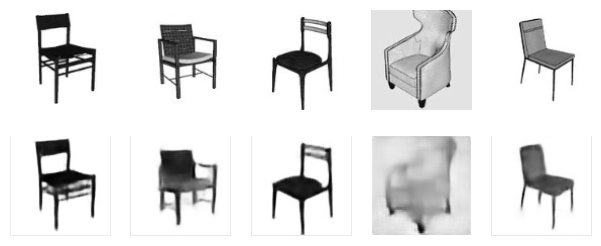

In [15]:
plot_reconstructions(autoencoder_vae)
plt.show()

In [97]:
predictions_vae = autoencoder_vae.predict(train_images)
print(type(predictions_vae))
print(predictions_vae.shape)

185/185 [==============================] - 2s 8ms/step
<class 'numpy.ndarray'>
(5913, 100, 100, 1)


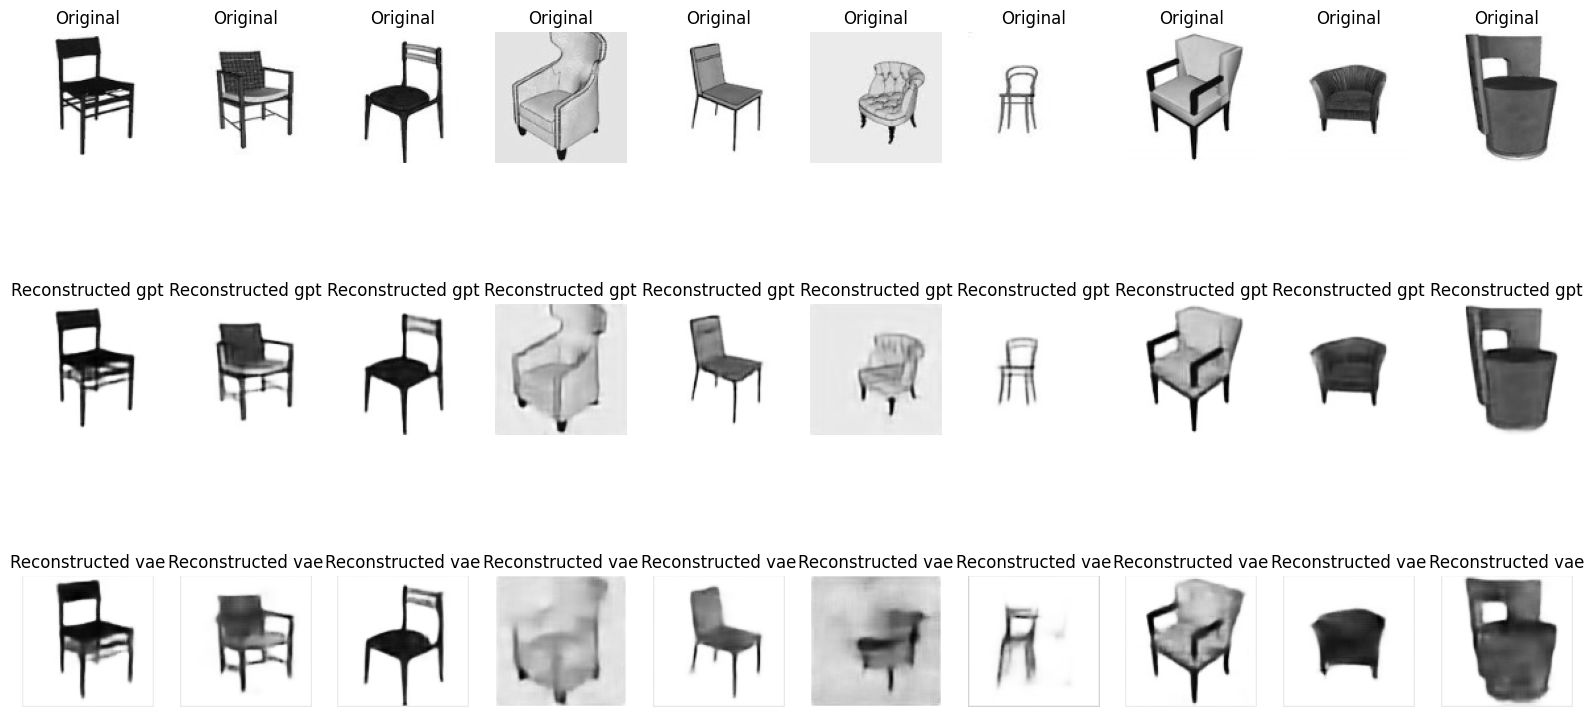

In [98]:
# Display original and reconstructed faces
plt.figure(figsize=(20, 10))
for i in range(num_chairs):
    # Original images
    plt.subplot(3, num_chairs, i + 1)
    plt.imshow(train_images[i],cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Reconstructed images from gpt model
    plt.subplot(3, num_chairs, i + 1 + num_chairs)
    plt.imshow(decoded_imgs[i],cmap='gray')
    plt.title('Reconstructed gpt')
    plt.axis('off')
    
    
    # Reconstructed images from vae model
    plt.subplot(3, num_chairs, i + 11 + num_chairs)
    plt.imshow(predictions_vae[i],cmap='gray')
    plt.title('Reconstructed vae')
    plt.axis('off')
    
    
plt.show()

In [100]:
#tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, 100])
random_images_vae = decoder_vae(codings).numpy()

codings_2 = tf.random.normal(shape=[21,13,13, 128])
random_images_gpt = decoder_gpt(codings_2).numpy()

In [101]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="gray")
        plt.axis("off")

In [102]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="gray")
        plt.axis("off")

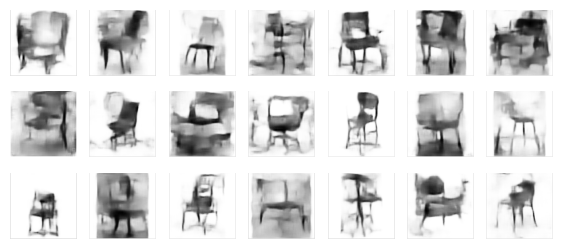

In [103]:
plot_multiple_images(random_images_vae, 7)
plt.show()

In [142]:
random_images_vae.shape

(21, 100, 100, 1)

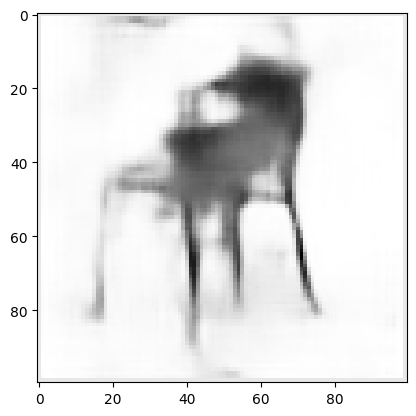

In [145]:
#save images
#for i in range(random_images_vae.shape[0]):
#    plt.imshow(random_images_vae[i],cmap='gray')
#    plt.savefig('image'+str(i)+'.png')



In [104]:
#tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = np.zeros([7, 100])
codings[:,3 ] = np.linspace(-0.8, 0.8,7)  # axis 3 looks best in this case
images = decoder_vae(codings).numpy()

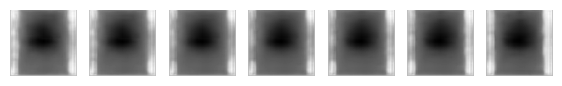

In [105]:
# extra code – this cell generates and saves Figure 17–13
plot_multiple_images(images)
plt.show()

1/1 [==============================] - 0s 16ms/step


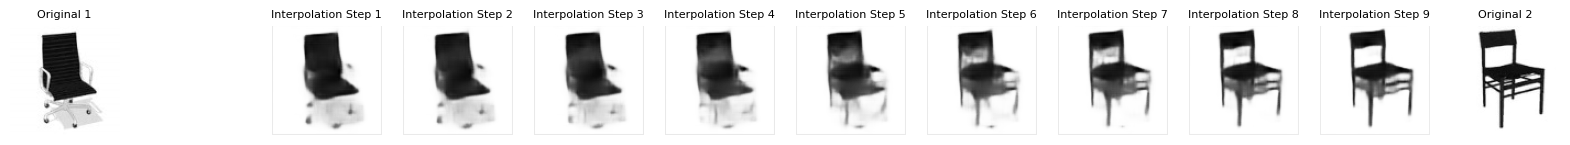

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Select two images from the training set
image1 = train_images[0]  # Replace with actual indices
image2 = train_images[10]  # Replace with actual indices

# Encode the images
_, _, encoding1 = encoder_vae.predict(np.array([image1]))
_, _, encoding2 = encoder_vae.predict(np.array([image2]))

# Interpolate between the encodings
interpolated_encodings = []
for i in range(10):
    alpha = i / 10.0
    interpolated_encoding = alpha * encoding1 + (1 - alpha) * encoding2
    interpolated_encodings.append(interpolated_encoding)

# Decode the interpolated encodings
reconstructed_images = []
for interpolated_encoding in interpolated_encodings:
    interpolated_encoding_reshaped = interpolated_encoding.reshape((1, 100))  # Reshape to (1, 100)
    reconstructed_image = decoder_vae.predict(interpolated_encoding_reshaped)
    reconstructed_images.append(reconstructed_image.squeeze())

# Plot the original images and their corresponding reconstructions interleaved
plt.figure(figsize=(20, 10))

plt.subplot(1, 12, 1)
plt.imshow(image2,cmap='gray')
plt.title('Original 1',fontsize=8)
plt.axis('off')

for i, reconstructed_image in enumerate(reconstructed_images):
    plt.subplot(1, 12, i + 3)
    plt.imshow(reconstructed_image.squeeze(),cmap='gray')
    plt.title(f'Interpolation Step {i + 1}',fontsize=8)
    plt.axis('off')
    
plt.subplot(1, 12, 12)
plt.imshow(image1,cmap='gray')
plt.title('Original 2',fontsize=8)
plt.axis('off')

plt.show()


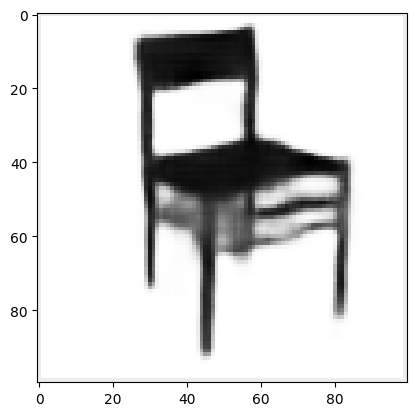

In [147]:
#save images
for i in range(len(reconstructed_images)):
    plt.imshow(reconstructed_images[i],cmap='gray')
    plt.savefig('image'+str(i)+'.png')

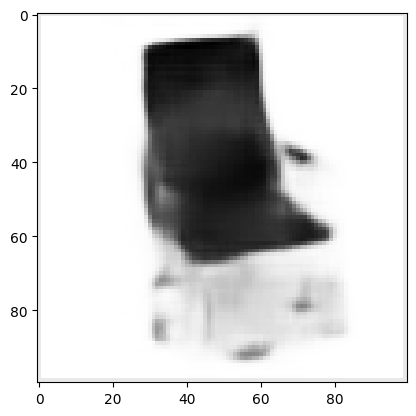

In [140]:
plt.imshow(reconstructed_images[2],cmap='gray')

(-0.5, 99.5, 99.5, -0.5)

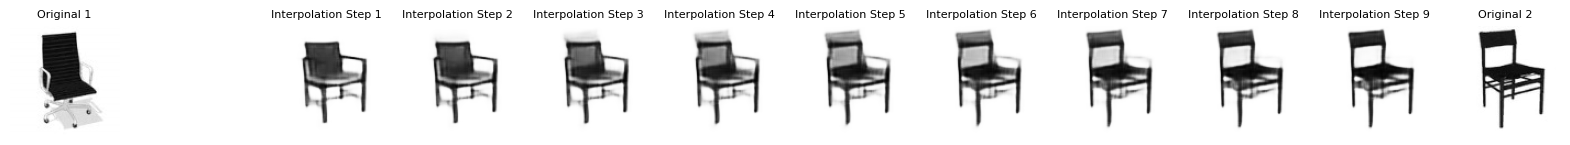

In [52]:
# Visualize the reconstructed images of the interpolations
plt.figure(figsize=(20, 10))
# for i, reconstructed_image in enumerate(decoded_interpolations):
#     plt.subplot(1, 5, i + 1)
#     plt.imshow(reconstructed_image.squeeze())
#     plt.title(f'Interpolation Step {i + 1}')
#     plt.axis('off')
# plt.show()

# Plot the first original image
plt.subplot(1, 12, 1)
plt.imshow(image2,cmap='gray')
plt.title('Original 1',fontsize=8)
plt.axis('off')

# Plot the reconstructed images of the interpolations
for i, reconstructed_image in enumerate(decoded_interpolations):
    plt.subplot(1, 12, i + 3)
    plt.imshow(reconstructed_image.squeeze(),cmap='gray')
    plt.title(f'Interpolation Step {i + 1}',fontsize=8)
    plt.axis('off')

# Plot the second original image
plt.subplot(1, 12, 12)
plt.imshow(image1,cmap='gray')
plt.title('Original 2',fontsize=8)
plt.axis('off')

----------

In [ ]:
# below is a Generative Adversarial Networks (GAN) in Tensorflow Tutorial on youtube
# https://www.youtube.com/watch?v=LZov6445YAY

In [126]:
from tensorflow.keras import layers

#create sampling layer
class SamplingLayer(layers.Layer):
    
    def call(self,inputs):
        '''Reparametrization trick z-mu +sigma +epsilon'''
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [127]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


def build_Encoder(latent_dim, encoderInputs):
    
    # Given a batch of images the convolutional block extracts the features
    l1 = Sequential([
        Conv2D(128, 3, activation='relu', strides=2, padding='same'),
        Conv2D(64, 3, activation='relu', strides=2, padding='same'),
        Flatten(),
        Dense(256, activation='relu')
    ])
    
    # Pass the inputs through the convolutional block
    x = l1(encoderInputs)
    
    # A dedicated layer to learn the mean in parallel
    zMean = Dense(latent_dim, name='z_mean')(x)
    
    # Now the parametrization layer to learn variance in parallel
    zLogVar = Dense(latent_dim, name='z_log_var')(x)
    
    # Now the reparametrization trick to find z as defined by mean and variance
    z = SamplingLayer()([zMean, zLogVar])
    
    return Model(encoderInputs, [zMean, zLogVar, z], name='encoder')

encoderInputs = Input(shape=(28, 28, 1))
encoder = build_Encoder(2, encoderInputs)
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential_6 (Sequential)   (None, 256)                  878144    ['input_24[0][0]']            
                                                                                                  
 z_mean (Dense)              (None, 2)                    514       ['sequential_6[0][0]']        
                                                                                                  
 z_log_var (Dense)           (None, 2)                    514       ['sequential_6[0][0]']        
                                                                                            

In [128]:
def buildDecoder(latentInputs):
    
    l1 = Sequential([
        Dense(7*7*64, activation='relu', input_shape=(latentInputs.shape[1],)),
        Reshape((7,7,64)),
        Conv2DTranspose(128,3,activation='relu',strides=2,padding='same'),
        Conv2DTranspose(64,3,activation='relu',strides=2,padding='same'),
        Conv2DTranspose(1,3,activation='sigmoid',strides=1,padding='same'),
    ])
    
    return Model(latentInputs, l1(latentInputs), name='decoder')

latent_inputs = Input(shape=(2,))
decoder = buildDecoder(latent_inputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 2)]               0         
                                                                 
 sequential_7 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157633 (615.75 KB)
Trainable params: 157633 (615.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [129]:
#this penalizes images that are not similar to the original images
def reconstructionLoss(data, reconstructed):
    return tf.reduce_mean(
    tf.reduce_sum(binary_crossentropy(data, reconstructed),
    axis=(1,2)
                 ))

In [130]:
def klDivergenceLoss(zMean,zLogVar):
    return tf.reduce_mean(
    tf.reduce_sum(
    -0.5 * (1 + zLogVar - tf.square(zMean) -tf.exp(zLogVar)),
           axis=1
           ))

In [131]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
    loss1 = reconstructionLoss(data, reconstructed)
    loss2 = klDivergenceLoss(zMean, zLogVar)
    klweight = 3.0
    return loss1, loss2, loss1+ klweight * loss2

In [132]:
from tensorflow import keras

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder= encoder
        self.decoder= decoder
        
        #register total loss as a metric in the model history
        self.totalLossTracker = keras.metrics.Mean(name='total_loss')
        self.ceLossTracker = keras.metrics.Mean(name='ce_loss')
        self.klLossTracker = keras.metrics.Mean(name= 'kl_loss')
        
    #these are all observable metrics
    @property
    def metrics(self):
        return [
            self.totalLossTracker,
            self.ceLossTracker,
            self.klLossTracker
        ]
        
    #now calculate loss+calculate gradients +update weights
    def train_step(self,data):
        with tf.GradientTape() as tape:
            zMean, zLogVar, z = self.encoder(data)
            reconstruction = self.decoder(z)
            ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
        grads = tape.gradient(totalLoss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            
        
        #keep track of loss
        self.totalLossTracker.update_state(totalLoss)
        self.ceLossTracker.update_state(ceLoss)
        self.klLossTracker.update_state(klLoss)

        return {
            'total_loss':self.totalLossTracker.result(),
            'ce_loss':self.ceLossTracker.result(),
               
            'kl_loss':self.klLossTracker.result()
            }

In [133]:
vae = VAE(encoder, decoder)

In [134]:
from tensorflow.keras import optimizers
from tensorflow.keras.losses import binary_crossentropy

vae.compile(optimizer=optimizers.Adam(learning_rate=0.0001))
history = vae.fit(train_images_2, epochs =30, batch_size=32)

Epoch 1/30


ValueError: in user code:

    File "/home/alexp/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/alexp/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/alexp/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_171909/693262754.py", line 26, in train_step
        zMean, zLogVar, z = self.encoder(data)
    File "/home/alexp/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/alexp/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "encoder" is incompatible with the layer: expected shape=(None, 28, 28, 1), found shape=(None, 100, 100)


In [ ]:
plt.figure(figsize=(10,9))
plt.plot(history.history.get('total_loss'),label='total_loss')


In [ ]:
synth = vae.decoder.predict([[1,2]])
plt.axis('off')
plt.imshow(synth.reshape((28,28)),cmap='gray')

In [ ]:
z = np.random.normal(loc=0, scale =4, size=(256,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(256):
    plt.subplot(16,16,i+1)
    plt.imshow(synth[i].reshape((28,28)),cmap='gray')
    plt.axis('off')
plt.show();

-------------

In [ ]:
# below is a code based on VAE cartoon 
# https://github.com/spmallick/learnopencv/blob/master/Variational-Autoencoder-TensorFlow/VAE_Cartoon_TensorFlow.ipynb

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dense, Flatten, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras import Model
import tensorflow.keras.backend as K

In [ ]:
def build_encoder_vae_2(input_shape):
    input_img = Input(shape=input_shape)
    
    #Block 1
    x = Conv2D(32, (3, 3), strides=2, padding='same',name='conv1')(input_img)
    x = BatchNormalization(name='bn_1')(x)
    
    
    x = LeakyReLU(name='lrelu_1')(x)
  
    # Block-2
    x = Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = BatchNormalization(name='bn_2')(x)
    x = LeakyReLU(name='lrelu_2')(x)
   
    # Block-3
    x = Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = BatchNormalization(name='bn_3')(x)
    x = LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = BatchNormalization(name='bn_4')(x)
    x = LeakyReLU(name='lrelu_4')(x)
  
    # Block-5
    x = Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = BatchNormalization(name='bn_5')(x)
    x = LeakyReLU(name='lrelu_5')(x)
 

    # Final Block
    flatten = Flatten()(x)
    mean = Dense(200, name='mean')(flatten)
    log_var = Dense(200, name='log_var')(flatten)
    model = Model(input_img, (mean, log_var), name="Encoder")
    return model



def build_decoder_vae_2(encoded_shape):
    input_encoded = Input(shape=encoded_shape)
    x = Dense(4096, name='dense_1')(input_encoded)
    x = Reshape((8,8,64), name='Reshape')(x)
    
    # Block-1
    x = Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = BatchNormalization(name='bn_1')(x)
    x = LeakyReLU(name='lrelu_1')(x)
   
    # Block-2
    x = Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = BatchNormalization(name='bn_2')(x)
    x = LeakyReLU(name='lrelu_2')(x)
 
    # Block-3
    x = Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = BatchNormalization(name='bn_3')(x)
    x = LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = BatchNormalization(name='bn_4')(x)
    x = LeakyReLU(name='lrelu_4')(x)

  
    # Block-5
    outputs = Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = Model(input_encoded, outputs, name="Decoder")
    return model


# Define input shape
input_shape = (256, 256, 3)

# Build encoder and decoder
encoder_vae_2 = build_encoder_vae_2(input_shape)
print(encoder_vae_2.output_shape)
decoder_vae_2 = build_decoder_vae_2((None,200))

# Define sampling function
def sampling(args):
    mean, log_var = args
    epsilon = K.random_normal(shape=(K.shape(mean)[0], 200), mean=0., stddev=1.)
    return mean + K.exp(log_var / 2) * epsilon

# Modify autoencoder definition
input_img = Input(shape=input_shape)
mean, log_var = encoder_vae_2(input_img)
encoded = Lambda(sampling, output_shape=(200,), name='sampling')([mean, log_var])
decoded = decoder_vae_2(encoded)
autoencoder_vae_2 = Model(input_img, decoded)




In [ ]:

# Compile and train the model as before
autoencoder_vae_2.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
autoencoder_vae_2.fit(train_2_images, train_2_images, epochs=20, batch_size=16, shuffle=True)

In [ ]:
# Reconstruct chair images
num_chairs = 10
encoded_imgs = encoder_vae_2.predict(train_2_images[:num_chairs])
decoded_imgs = decoder_vae_2.predict(encoded_imgs[0])



# Display original and reconstructed faces
plt.figure(figsize=(20, 4))
for i in range(num_chairs):
    # Original images
    plt.subplot(3, num_chairs, i + 1)
    plt.imshow(train_2_images[i])
    plt.title('Original')
    plt.axis('off')

    # Reconstructed images from gpt model
    plt.subplot(3, num_chairs, i + 1 + num_chairs)
    plt.imshow(decoded_imgs[i])
    plt.title('Reconstructed gpt')
    plt.axis('off')
    

    
    
plt.show()

-------------------------------------

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense, ZeroPadding2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def sampling(args):
    '''Reparametrization trick z-mu +sigma +epsilon'''
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_encoder_vae(input_shape, encoding_dim):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    flattened = Flatten()(x)
    z_mean = Dense(encoding_dim, name='z_mean')(flattened)
    z_log_var = Dense(encoding_dim, name='z_log_var')(flattened)
    z = Lambda(sampling, output_shape=(encoding_dim,), name='z')([z_mean, z_log_var])
    return Model(input_img, [z_mean, z_log_var, z])

def build_decoder_vae(encoded_dim, input_shape):
    input_encoded = Input(shape=(encoded_dim,))
    x = Dense(8 * 8 * 128, activation='relu')(input_encoded)  # Adjust the number of neurons
    x = Reshape((8, 8, 128))(x)  # Reshape to match the shape after the last pooling layer in the encoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Change padding to 'same'
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Change padding to 'same'
    return Model(input_encoded, decoded)

# Define input shape and encoding dimension
input_shape = (64, 64, 1)  # Modify input shape
encoding_dim = 50  # Example encoding dimension

# Build encoder and decoder
encoder_vae = build_encoder_vae(input_shape, encoding_dim)
print(encoder_vae.output_shape)

decoder_vae = build_decoder_vae(encoding_dim, input_shape)

# Combine encoder and decoder into autoencoder
input_img = Input(shape=input_shape)
z_mean, z_log_var, z = encoder_vae(input_img)
decoded = decoder_vae(z)
autoencoder_vae = Model(input_img, decoded)

# Define the VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(decoded))
reconstruction_loss *= input_shape[0] * input_shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
autoencoder_vae.add_loss(vae_loss)

# Compile the VAE
autoencoder_vae.compile(optimizer='adam')

# Train the model
autoencoder_vae.fit(train_images, epochs=50, batch_size=64, shuffle=True)
